# Hidden Markov Models

## Generating data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#let's say we have only two hidden states
z_val = np.array([0,1])

prob = np.array([.5,.5])
A = np.array([[.98,.02],[.02,.98]]) #transition matrix
B_pars = np.array([[0,.5],[5,.5]])

150


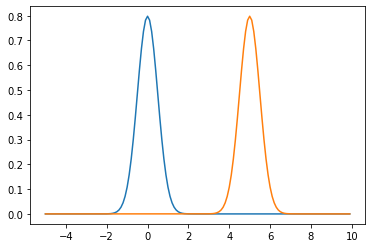

In [3]:
def gaussian(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-((x-mu)**2)/(2*sigma**2))

xt = np.arange(-5,10,.1)
y1=[]
y2=[]
for i in range(len(xt)):
    y1.append(gaussian(xt[i],B_pars[0][0], B_pars[0][1]))
    y2.append(gaussian(xt[i],B_pars[1][0], B_pars[1][1]))
    
plt.plot(xt,y1)
plt.plot(xt,y2)
print(len(xt))

In [4]:
def generate_initial_state(N, prob, B_pars):
    z = np.empty((N)) #hidden state sequence
    x = np.empty((N)) #observations
    
    #Generating first state and emission
    r = np.random.random()
    z[0] = np.where(r <= prob[0], 0, 1)
    x[0] = np.random.normal(loc=B_pars[0][0], scale=B_pars[0][1])

    return z, x

def generate_sequence(N, z, x, c, B_pars):
    for i in range(1, N):
        a = np.random.random()
        if z[i-1] == 0:
            z[i] = np.where(a <= c[0], 0, 1)
            x[i] = np.random.normal(loc=B_pars[0][0], scale=B_pars[0][1])
        else:
            z[i] = np.where(a <= c[1], 1, 0)
            x[i] = np.random.normal(loc=B_pars[1][0], scale=B_pars[1][1])
    return z, x


In [5]:
N = 100 #length of sequence
c = np.array([A[0,0],A[1,1]])# Transition probabilities

#generate the arrays z and x for the hidden state sequence and observations
z,x=generate_initial_state(N, prob, B_pars)
z,x=generate_sequence(N, z, x, c, B_pars)

In [6]:
A[1,1]

0.98

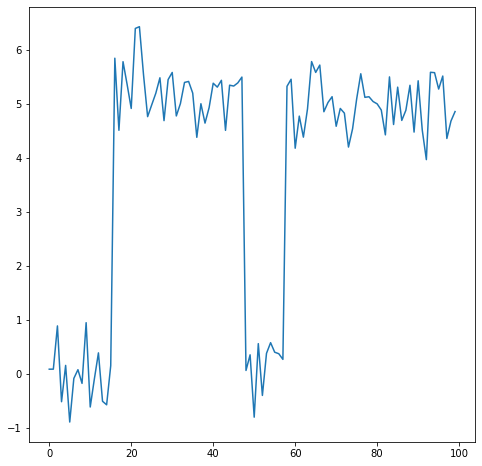

In [7]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,N,1),x[:N])

In [8]:
x_0 = x[np.where(z==0)]
print(x_0[:10])

[ 0.08566795  0.0861436   0.88683374 -0.51640966  0.15581633 -0.8927507
 -0.08512381  0.07638134 -0.1771336   0.94664089]


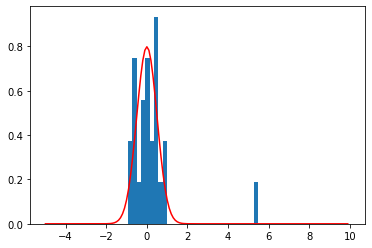

In [9]:
plt.hist(x_0, bins=70, range=(-5,10), density=True)
plt.plot(xt,y1,color='red')

In [10]:
#unique_0, counts_0 = np.unique(x_0, return_counts=True)

In [11]:
#plt.plot(unique_0,counts_0,'o')

In [12]:
x_0.mean()

0.24597323903569712

In [13]:
x_1 = x[np.where(z==1)]

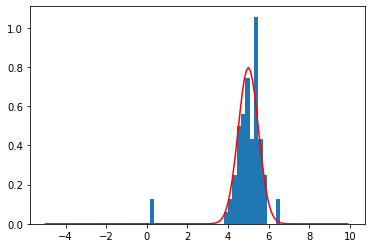

In [14]:
plt.hist(x_1, bins=70, range=(-5,10), density=True)
plt.plot(xt,y2,color='red')

In [15]:
#plt.plot(unique_1,counts_1,'o')

In [16]:
x_1.mean()

4.955762156966448

# 1. EXPECTATION

## Forward and backward algorithm
The forward and backward algorithm are dynamic programming algorithms that compute the probability of observing a sequence of observations given an HMM. The forward algorithm works by computing the alpha values recursively using the initial probabilities, transition probabilities, and observation probabilities of the HMM. The backward algorithm proceeds in a similar way but it starts from the last time step, working backwards.

The alpha variable represents the probability of observing the first t observations and being in state i at time t:
\begin{equation}
\alpha_t(i) = P(x_{1:t}, z_t = i)
\end{equation}
where $x_{1:t}$ are the first t observations, $z_t$ is the state at time t.

The beta variable represents the probability of observing the remaining observations from time t+1 to the end, given that we are in state i at time t: 
\begin{equation}
\beta_t(i) = P(x_{t+1:T} | z_t = i)
\end{equation}
where $x_{t+1:T}$ are the remaining observations after time t.
The alpha and beta variable are typically computed recursively using the following formulas:

\begin{equation}
\alpha_{t}(j) = \sum_{i=1}^{N} \alpha_{t-1}(i) a_{ij} b_j(z_{t+1})
\end{equation}

\begin{equation}
\beta_t(i) = \sum_{j=1}^{N} a_{ij} b_j(x_{t+1}) \beta_{t+1}(j)
\end{equation}

where $N$ is the number of states in the HMM, $a_{ij}$ is the probability of transitioning from state i to state j, $b_j(x_{t+1})$ is the probability of observing the next observation $x_{t+1}$ given that we are in state j. The $\alpha_t(i)$ term is the alpha value for state i at time t and $\beta_{t+1}(j)$ is the beta value for state j at time $t+1$.

In [17]:
A = np.array([[.98,.02],[.02,.98]]) #transition matrix

def calculate_emission_matrix(B_pars, x):
    b = np.zeros((2, len(x)))# Create emission probability matrix b
    T=len(x)
    for i in range(T):
        b[0, i] = gaussian(x[i], B_pars[0][0], B_pars[0][1])
        b[1, i] = gaussian(x[i], B_pars[1][0], B_pars[1][1])
    return b


def forward_algorithm(x, A, b, pi=prob[0]):
    # x: observed sequence (array of shape (T,))
    # A: transition probability matrix (array of shape (2, 2))
    # b: emission probability matrix (array of shape (2, T))
    # pi: initial state distribution (array of shape (2,))
    # returns: alpha, the forward variable (array of shape (2, T))

    T = len(x)
    alpha = np.zeros((2, T))

    # initialization of the first alpha
    alpha[:, 0] = (pi * b[:, 0])
    
    # recursion
    for t in range(1, T):
        for j in range(2):
            alpha[j, t] = np.sum(alpha[:, t-1] * A[:, j]) * b[j, t]
        #alpha[:,t]=alpha[:, t]/np.sum(alpha[:,t])

    return alpha


def backward_algorithm(x, A, b):
    # x: observed sequence (array of shape (T,))
    # A: transition probability matrix (array of shape (2, 2))
    # b: emission probability matrix (array of shape (2, T))
    # returns: beta, the backward variable (array of shape (2, T))

    T = len(x)
    beta = np.zeros((2, T))

    # initialization of the last beta
    #we assume that in the HMM the probability of observing the last observation given any state at time T is 1
    #Here -1 index represents the last column of the matrix, regardless of the total number of columns
    beta[:, -1] = 1

    # recursion
    for t in range(T-2, -1, -1):
        for j in range(2):
            beta[j, t] = np.sum(beta[:, t+1]*A[j, :]*b[:, t+1])
        #beta[:,t]=beta[:, t]/np.sum(beta[:,t])

    return beta

In [18]:
b=calculate_emission_matrix(B_pars, x)
alphas=forward_algorithm(x, A, b, pi=prob[0])
betas =backward_algorithm(x, A, b)

In [19]:
print(z)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


### Avoiding overflow

To avoid overflow in the calculations of gamma and beta, we can rewrite them as exponentials ($\alpha = e^{l}$) and compute $l$ instead; in this way, all the products turn into sums and the algorithm is robust against overflow even for larger N.

In [20]:
def forward_opt(x, A, b, pi=prob):
    T = len(x)
    alpha = np.zeros((2,T))
    l = np.zeros((2,T))

    alpha[:, 0] = pi[:] * b[:, 0]
    l[0,0] = np.log(alpha[0,0])
    l[1,0] = np.log(alpha[1,0])

    y = np.zeros((2))
    for t in range(1, T):
        for j in range(2):
            y[0] = np.log(b[j,t])+np.log(A[0,j])+l[0,t-1]
            y[1] = np.log(b[j,t])+np.log(A[1,j])+l[1,t-1]
            l[j,t] = np.log(np.exp(y[0])+np.exp(y[1]))
            ymax = y.max()
            l[j,t] = ymax+np.log(np.exp(y[0]-ymax)+np.exp(y[1]-ymax))
            
            alpha[j,t] = np.exp(l[j,t])
        #alpha[:,t]=alpha[:, t]/np.sum(alpha[:,t])
    return alpha

In [21]:
b=calculate_emission_matrix(B_pars, x)
alphas=forward_algorithm(x, A, b, pi=prob)
alphas_opt = forward_opt(x,A,b,prob)

In [22]:
print('Alphas calculate directly: \n')
print(alphas[:,40:50], '\n\n')
print('Alphas with log-sum-exp trick: \n')
print(alphas_opt[:,40:50],)

Alphas calculate directly: 

[[3.31027854e-44 9.08074503e-44 3.89286294e-45 2.09519195e-37
  7.06908099e-45 6.12684976e-45 1.10301146e-45 6.14827292e-47
  4.84352010e-21 2.95789094e-21]
 [1.69080821e-17 1.09352762e-17 5.86286889e-18 2.82384295e-18
  1.74295510e-18 1.09904036e-18 6.37441154e-19 3.05870126e-19
  1.58392657e-40 1.31693456e-41]] 


Alphas with log-sum-exp trick: 

[[3.31027854e-44 9.08074503e-44 3.89286294e-45 2.09519195e-37
  7.06908099e-45 6.12684976e-45 1.10301146e-45 6.14827292e-47
  4.84352010e-21 2.95789094e-21]
 [1.69080821e-17 1.09352762e-17 5.86286889e-18 2.82384295e-18
  1.74295510e-18 1.09904036e-18 6.37441154e-19 3.05870126e-19
  1.58392657e-40 1.31693456e-41]]


In [23]:
def backward_opt(x, A, b):
    T = len(x)
    beta = np.zeros((2,T))
    l = np.zeros((2,T))

    beta[:, -1] = 1
    l[0,-1] = np.log(beta[0,-1])
    l[1,-1] = np.log(beta[1,-1])

    y = np.zeros((2))
    for t in range(T-2, -1, -1):
        for j in range(2):
            y[0] = np.log(b[0,t+1])+np.log(A[j,0])+l[0,t+1]
            y[1] = np.log(b[1,t+1])+np.log(A[j,1])+l[1,t+1]
            ymax = y.max()
            l[j,t] = ymax+np.log(np.exp(y[0]-ymax)+np.exp(y[1]-ymax))
            
            beta[j,t] = np.exp(l[j,t])
       
        #beta[:,t]=beta[:, t]/np.sum(beta[:,t])
    return beta

In [24]:
b = calculate_emission_matrix(B_pars, x)
betas = backward_algorithm(x, A, b)
betas_opt = backward_opt(x,A,b)

In [25]:
print('betas calculate directly: \n')
print(betas[:,40:50], '\n\n')
print('betas with log-sum-exp trick: \n')
print(betas_opt[:,40:50],)

betas calculate directly: 

[[1.74284378e-22 2.69477835e-22 5.02623309e-22 1.04354761e-21
  1.69070022e-21 2.68126146e-21 4.62288094e-21 2.31317189e-17
  2.98117713e-17 4.88165103e-17]
 [8.53993452e-21 1.32044139e-20 2.46285421e-20 5.11338329e-20
  8.28443106e-20 1.31381811e-19 2.26521166e-19 4.72075896e-19
  6.08403496e-19 9.96255312e-19]] 


betas with log-sum-exp trick: 

[[1.74284378e-22 2.69477835e-22 5.02623309e-22 1.04354761e-21
  1.69070022e-21 2.68126146e-21 4.62288094e-21 2.31317189e-17
  2.98117713e-17 4.88165103e-17]
 [8.53993452e-21 1.32044139e-20 2.46285421e-20 5.11338329e-20
  8.28443106e-20 1.31381811e-19 2.26521166e-19 4.72075896e-19
  6.08403496e-19 9.96255312e-19]]


### Probability
we now can compute $p(z_t|x)=\alpha_t*\beta_t$

In [26]:
#conditional probability of having a certain hidden value at time t: alpha(0,t)*beta(0,t) or alpha(1,t)*beta(1,t)
#define an array of probabilities p(2,N): to each column corresponds the probability of having, respectively, z=0 or z=1
p_zx = np.zeros((2,N))
for t in range(N):
    p_zx[0,t]=(alphas_opt[0,t]*betas_opt[0,t])
    p_zx[1,t]=(alphas_opt[1,t]*betas_opt[1,t])
    #normalizing:
    p_zx[:,t]=p_zx[:,t]/np.sum(p_zx[:,t])

#Here we define the most probable sequence, this is just to check if it works but shouldn't be done in the training
z_exp = np.zeros((N,))
for t in range(N):
    r = np.random.random()
    if r<=p_zx[0,t]:
        z_exp[t]=0
    elif r<=p_zx[0,t]+p_zx[1,t]:
        z_exp[t]=1
        
        
check = np.full((N,),False)
for i in range(N):
    if z_exp[i]==z[i]:
        check[i]='True'
check

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# 2. MAXIMIZATION

## Gamma and Psi

\begin{equation}
\gamma_t(i) = \frac{\alpha_t(i)\beta_t(i)}{\sum_{j=1}^{N}\alpha_t(j)\beta_t(j)}
\end{equation}

where $N$ is the number of states in the HMM, $\alpha_t(i)$ is computed at time $t$ and state $i$, and $\beta_t(i)$ is computed at time $t$ and state $i$. This formula computes the probability of being in state $i$ at time $t$, given the observed sequence and the HMM parameters.

The formula for the psi value at time step $t$, current state $i$, and next state $j$ is:

\begin{equation}
\psi_t(i,j) = \frac{\alpha_t(i)a_{ij}b_j(x_{t+1})\beta_{t+1}(j)}{\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_t(i)a_{ij}b_j(x_{t+1})\beta_{t+1}(j)}
\end{equation}

where $N$ is the number of states in the HMM, $a_{ij}$ is the transition probability from state $i$ to state $j$, $b_j(x_{t+1})$ is the emission probability of the observation $x_{t+1}$ given state $j$, and $\beta_{t+1}(j)$ is the backward variable at time $t+1$ and state $j$. 

In [27]:
#gamma[0][i] = alpha[0][i]*beta[0][i]/(alpha[0][i]*beta[0][i]+alpha[1][i]*beta[1][i] )
#gamma[1][i] =  alpha[1][i]*beta[1][i]/(alpha[0][i]*beta[0][i]+alpha[1][i]*beta[1][i] )
  
def get_gamma(x, alpha, beta):
    n = alpha.shape[0]  # number of states
    T = len(x)
    gamma = np.zeros((n, T))

    for t in range(T):
        norm = np.sum(alpha[:, t] * beta[:, t]) #dot product
        for i in range(n):
            gamma[i, t] = (alpha[i, t] * beta[i, t]) / norm

    return gamma


#This is how calculate_psi was calculated before the modification

#def calculate_psi(t, i, j, alpha, beta, A, b):
#    denom = alpha[j][t] * beta[j][t] * A[j][i] * b[i][t+1]
#    return (alpha[i][t] * A[i][j] * beta[j][t+1] * b[j][t+1]) / denom

#This is what i modified: 
# Changed the order to compare better with the formula 
# Changed the index t of beta
# Changed how the denominator is deined
def calculate_psi(t, i, j, alpha, beta, A, b):
    
    #numerator
    num = alpha[i][t] * A[i][j] * b[j][t+1]* beta[j][t+1]

    #compute denominator
    denom=0
    for a in range(alpha.shape[0]):
        denom+=alpha[a][t]*np.sum(A[a,:] * b[:,t+1]* beta[:,t+1])
    
    return num/denom

def get_psi(x, beta, alpha, A, b):
    n = alpha.shape[0]  # number of states
    psi = np.zeros((n, n, len(x)))
    for t in range(1, len(x)-1):
        for j in range(n):  # z_t = j
            for i in range(n):  # z_t+1 = i
                psi[i][j][t] = calculate_psi(t, i, j, alpha, beta, A, b)
    return psi
 

In [28]:
gamma=get_gamma(x,alphas_opt,betas_opt)

### Likelihood
The goal of expectation-maximization (EM) algorithm is to find the parameters $\Lambda = \{\pi_i, a_{ij}, b_j(k)\}$ that maximize the log-likelihood function. Since we already have the values of alpha, we can compute the loglikelihood directly by summing over the last column of alpha, which gives us the probability of observing the entire sequence $x$ given the model parameters $\Lambda$:
$$ {\mathcal{L}}_{\theta} = \ln p_{\theta}(z,x) = \ln \sum_{i=1}^N \alpha_{i,T}$$

This equation represents the probability of observing the entire sequence $X$ given the model parameters $\theta$. The summation is over all possible states $i$ in the HMM, and $\alpha_{i,T}$ is the value of the forward variable for state $i$ at the last time step $T$.

In [29]:
def compute_likelihood(x, alpha):
    """
    Compute the likelihood of a sequence of observed symbols given an HMM with alpha known.
    
    Args:
        x:  array of observed states
        alpha: array (2 x T) of the alphas from forward algorithm
    Returns:
        likelihood:  the likelihood of the observed sequence given the HMM.
    """
    
    # The likelihood is the sum of the final alpha values
    likelihood =np.log(np.sum(alpha[:, -1]))
    
    return likelihood


In [30]:
compute_likelihood(x, alphas_opt)

-84.8282735513701

## Update: $\pi_i,a_{ij},b_i(x)$

## - $\pi_i$

In [31]:
def update_pi(K, N, prob, B_pars, A, c):
    K = 10
    N = 100 #(timesteps)
    prob_up = np.zeros((2,))
    gamma_k = np.zeros((2,K))

    for k in range(K): 
        
        # 
        z,x = generate_initial_state(N, prob, B_pars)
        z,x = generate_sequence(N, z, x, c, B_pars)
        #print("sequence 0 step")
        #print(z[0])

        b = calculate_emission_matrix(B_pars, x)
        alphas_opt = forward_opt(x,A,b,prob)
        betas_opt = backward_opt(x,A,b)

        gamma = get_gamma(x, alphas_opt, betas_opt)
        gamma_k[0,k] = gamma[0,1] #getting the first value of the sequence of gamma for z=0
        gamma_k[1,k] = gamma[1,1] #getting the first value of the sequence of gamma for z=1 
        #print("Gamma")
        #print(gamma[0,0])
        #print(gamma[1,0])

    prob_up[0] = np.sum(gamma_k[0,:])/K
    prob_up[1] = np.sum(gamma_k[1,:])/K

    return prob_up
    
#Why does it not work for gamma[0,0] but for gamma[0,1]?

In [32]:
gamma.shape

(2, 100)

In [33]:
K = 10
N = 100
update_pi(K, N, prob, B_pars, A, c)

array([0.5, 0.5])

## - $a_{ij}$

In [34]:
def update_a(N,psi, prob, B_pars, c, A):
    N = 100
    A_up = np.zeros((2,2))
    norm = np.zeros((N,))
    np.random.seed(1234)

    #z,x = generate_initial_state(N, prob, B_pars)
    #z,x = generate_sequence(N, z, x, c, B_pars)
    #b = calculate_emission_matrix(B_pars, x)
    #alphas_opt = forward_opt(x,A,b,prob)
    #betas_opt = backward_opt(x,A,b)

    #psi=get_psi(x, betas_opt, alphas_opt, A, b)

    for i in range(2):      #hidden states
        norm[i] = np.sum(psi[i,:,:])
        for j in range(2):
            A_up[i,j] = np.sum(psi[i,j,:])


    for i in range(2):      #hidden states
        for j in range(2):            
            A_up[i,j] = A_up[i,j]/(norm[i])
            #print(np.sum(A_up[i,:])/norm[i])

    return A_up


## - $b_i(x)$


In [35]:
def update_b(N,gamma, prob, B_pars, c,x):
    N = 100
    B_pars_up = np.zeros((2,2))
    np.random.seed(1234)

    #z,x = generate_initial_state(N, prob, B_pars)
    #z,x = generate_sequence(N, z, x, c, B_pars)
    #b = calculate_emission_matrix(B_pars, x)
    #alphas_opt = forward_opt(x,A,b,prob)
    #betas_opt = backward_opt(x,A,b)

    #gamma = get_gamma(x, alphas_opt, betas_opt)
    x_mu = np.zeros((2,N))

    for i in range(2):
        #update mus (mean of gaussians)
        B_pars_up[i,0]= np.sum(gamma[i,:]*x)/np.sum(gamma[i,:])  #sum over all t

        #update sigmas of gaussians
        x_mu[i,:] = x-B_pars[i,0] #x-mu_0, x-mu_1
        
    B_pars_up[0,1]= np.sum(gamma[0,:]*np.square(x_mu[0,:]))/np.sum(gamma[0,:])  #sum over all t

        #Before modification
        #B_pars_up[1,1]= np.sum(gamma[0,:]*np.outer(x_mu[0,:].T,x_mu[1,:]))/np.sum(gamma[1,:])

        #After changing the index in gamma
    B_pars_up[1,1]= np.sum(gamma[1,:]*np.square(x_mu[1,:]))/np.sum(gamma[1,:])  #sum over all t

    return (B_pars_up, x_mu)

In [36]:
B_pars_up,x_mu=update_b(N,gamma,prob,B_pars,c,x)

In [37]:
B_pars_up

array([[0.04128078, 0.23337286],
       [5.09132692, 0.24152077]])

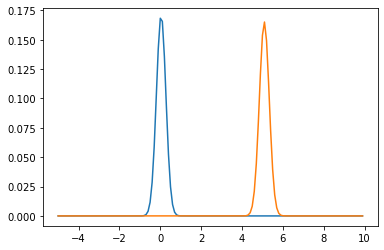

In [38]:
xt = np.arange(-5,10,.1)
y1=[]
y2=[]
for i in range(len(xt)):
    y1.append(gaussian(xt[i],B_pars_up[0][0], B_pars_up[0][1]))
    y2.append(gaussian(xt[i],B_pars_up[1][0], B_pars_up[1][1]))
    
y1=y1/np.sum(y1)
y2=y2/np.sum(y2)
plt.plot(xt,y1)
plt.plot(xt,y2)

# Training the model
Given the functions for expectation, maximization, backward, and forward, which have already been defined, a training function for a Hidden Markov Model can be written. This training function sequentially repeats the expectation-maximization algorithm until convergence is reached, defined as the point at which the parameter updates in maximization (i.e., pi, a, and b) do not change substantially

In [39]:
def training(x,A,b,c, prob, B_pars, N, K, n_iter=10000, tol=1e-6):
    
    # Initialize model parameters
    pi_ = prob
    a_ = A
    b_ = B_pars
    
    # Initialize convergence criterion
    diff_pi = 0
    diff_a = 0
    diff_b = 0
    
    #initialize log-likelihood array
    likelihood=np.zeros(n_iter)
    
    #initial step of expectation
    b=calculate_emission_matrix(B_pars, x) 
    alpha = forward_opt(x,A,b,prob)
    beta = backward_opt(x,A,b)
    gamma=get_gamma(x, alpha, beta)
    psi=get_psi(x, beta, alpha, A, b)
        
  # Iterate expectation-maximization algorithm until convergence
    for i in range(n_iter):
        
        # Maximization step
        pi_new = update_pi(K, N, pi_, b_, a_, c)
        a_new =  update_a(N,psi, pi_, b_, c, a_)
        b_new,_ =  update_b(N,gamma, pi_, b_, c,x)
        
        # Expectation step
        b=calculate_emission_matrix(b_new, x) 
        alpha = forward_opt(x, a_new, b, pi_new)
        beta = backward_opt(x, a_new, b)
        gamma=get_gamma(x, alpha, beta)
        psi=get_psi(x, beta, alpha, a_new, b) 
    
        # Check convergence
        diff_pi = sum(abs(pi_new - pi_))
        diff_a = sum(abs(a_new - a_))
        diff_b = sum(abs(b_new - b_))

        #if (diff_pi < tol).all() and (diff_a < tol).all() and (diff_b < tol).all():
            #break

        # Update parameters
        pi_ = pi_new
        a_ = a_new
        b_ = b_new
         
        #compute the likelihood    
        likelihood[i] = compute_likelihood(x, alpha)
        #print("Likelihood: {}".format(likelihood))
  
  # Return trained model parameters
    return (pi_,a_,b_,i,likelihood)

In [40]:
K=50
N=100
n_iter=50
pi_,a_,b_,_,likelihood=training(x,A,b,c, prob, B_pars, N, K, n_iter=100, tol=1e-6)

In [41]:
b_

array([[0.04128078, 0.23166876],
       [5.09132692, 0.23318016]])

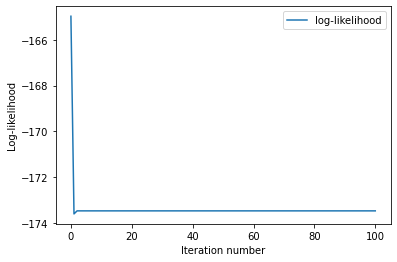

In [42]:
n_iter=100
plt.plot(np.linspace(0,n_iter,n_iter), likelihood, label='log-likelihood')
plt.xlabel('Iteration number')
plt.ylabel('Log-likelihood')
plt.legend()

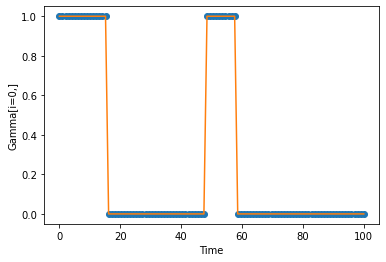

In [43]:
plt.plot(np.linspace(0,100,100), gamma[0,], 'o')
plt.plot(np.linspace(0,100,100), gamma[0,], '-')

# add labels and legend
plt.xlabel('Time')
plt.ylabel('Gamma[i=0,]')

# show plot
plt.show()

In [44]:
# Element-wise multiplication of alpha and beta
gamma = alphas_opt * betas_opt

# Column-wise normalization of gamma
col_sums = np.sum(gamma, axis=0, keepdims=True)
gamma = gamma / col_sums[0,0]

#print(gamma)

In [45]:
n=2
T=len(x)
xi = np.zeros((n, n, T-1))

for t in range(T-1):
    for i in range(n):
        for j in range(n):
            xi[i, j, t] = alphas_opt[i, t] * A[i, j] * b[j, t+1] * betas_opt[j, t+1]

    xi[:, :, t] /= xi[:, :, t].sum()

## Viterbi Algorithm


In [45]:
def viterbi(x, A, b, pi):
    """our variables
        x: observed sequence (array of shape (T,))
        A: transition probability matrix (array of shape (2, 2))
        b: emission probability matrix (array of shape (2, T))
        pi:initial state distribution (array of shape (2,))
    """
    T = len(x)
    z = np.zeros(T)
    index = np.zeros(T)
    mu = np.zeros((2,T))
    t2 = np.zeros((2,T))
    
    mu [:,0]= pi*b[:,0]
    mu[:,0]/=mu[:,0].sum() #normalize
    
    t2[:, 0] = 0
        
    for t in range(1,T):
        mu[:,t] = np.max(mu[:,t-1]*A*b[:,t],axis=1)    #calculate mu at time t (max evaluated for each column)
        t2[:,t] = np.argmax(mu[:,t-1]*A*b[:,t],axis=1) #evaluated over each column
        mu[:,t]/= mu[:,t].sum()

            
    index = np.argmax(mu, axis=0) #index of state that maximizes mu at each t (needs to be shifted because index[0]
                                  # has to be computed)
    #print(index)
    #print(t2)
    
    
    for i in reversed(range(1, T)):
        index[i-1] = t2[index[i], i]       #list of indices of z, shifted; index[i]=row 0 or 1, i=t
        z[i-1] = z_val[index[i-1]]         #value of most probable state z
    #print(index)              
    return z
    
    
    


In [46]:
b = calculate_emission_matrix(b_,x) #emission matrix calculated with final b_
z_pred = viterbi(x,a_,b,pi_) #calculated with final a_ and pi_ 

In [47]:
z_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [48]:
#real values
z

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [49]:
#What if I use the initial values?
b = calculate_emission_matrix(B_pars,x) 
z_pred = viterbi(x,A,b,prob)

In [50]:
z_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])